In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
import torch.nn.functional as F  
import torchvision.models as models  # Import this line to access pre-trained models
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc


In [3]:
# Paths to the files
label_file_path = r"F:\Awais_data\Datasets\PartialSpoof\database_segment_labels\database\segment_labels\train_seglab_0.16.npy"
csv_dir_path = r"C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1"
csv_file_template = os.path.join(csv_dir_path, "train_segment_merged_part_{}.csv")

# Load segment labels from .npy file
segment_labels = np.load(label_file_path, allow_pickle=True).item()

# Function to check the number of segment labels and features
def diagnose_features_and_labels():
    # Initialize dictionary to store diagnostics
    diagnostics = {}
    
    # Iterate through all 7 CSV files
    for part in range(1, 20):
        csv_file = csv_file_template.format(part)
        
        # Load the CSV file
        if not os.path.exists(csv_file):
            print(f"CSV file not found: {csv_file}")
            continue
        print(f"Processing {csv_file}...")
        df = pd.read_csv(csv_file)
        
        # Iterate through each row in the CSV file
        for _, row in df.iterrows():
            file_id = row.iloc[0]  # File ID is in the first column
            
            # Check if the file ID exists in the segment labels
            if file_id in segment_labels:
                num_segment_labels = len(segment_labels[file_id])
                # Track the count of features for this file_id
                if file_id not in diagnostics:
                    diagnostics[file_id] = {"labels_count": num_segment_labels, "features_count": 0}
                diagnostics[file_id]["features_count"] += 1

    # Analyze mismatches and missing file IDs
    mismatched_files = []
    missing_file_ids = set(segment_labels.keys()) - set(diagnostics.keys())

    for file_id, counts in diagnostics.items():
        if counts["labels_count"] != counts["features_count"]:
            mismatched_files.append(
                (file_id, counts["labels_count"], counts["features_count"])
            )

    # Print results
    if mismatched_files:
        print("Mismatched files (file_id, labels_count, features_count):")
        for file_id, labels_count, features_count in mismatched_files:
            print(f"File: {file_id} | Labels: {labels_count} | Features: {features_count}")
    else:
        print("No mismatches found.")

    print(f"\nNumber of audio files in labels but not in features: {len(missing_file_ids)}")
    if missing_file_ids:
        print("Missing file IDs:")
        print(", ".join(list(missing_file_ids)))

# Run the diagnosis
diagnose_features_and_labels()


Processing C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_1.csv...
Processing C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_2.csv...
Processing C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_3.csv...
Processing C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_4.csv...
Processing C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_5.csv...
Processing C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_6.csv...
Processing C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_7.csv...
CSV file not found: C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_8.csv
CSV file not found: C:\Notebooks\rrl_source\datase

In [5]:
# --------- 1. Merge CSV Files ---------
def merge_csv_files(directory, output_file, prefix="train_segment_merged_part_"):
    # Identify files with the specified prefix and .csv extension
    csv_files = [os.path.join(directory, f) for f in os.listdir(directory) 
                 if f.startswith(prefix) and f.endswith('.csv')]
    
    # Load and concatenate all identified files
    df_list = []
    for file in csv_files:
        print(f"Reading file: {file}")  # Print the name of each file being read
        df_list.append(pd.read_csv(file))
    
    merged_df = pd.concat(df_list, ignore_index=True)
    
    # Save the merged dataframe to a single CSV file
    merged_df.to_csv(output_file, index=False)
    return merged_df

# Merge the files
csv_dir = r"C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1"
output_file = "merged_features.csv"
merged_data = merge_csv_files(csv_dir, output_file)

# Verify the result
print(f"Merged data shape: {merged_data.shape}")


Reading file: C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_1.csv
Reading file: C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_2.csv
Reading file: C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_3.csv
Reading file: C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_4.csv
Reading file: C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_5.csv
Reading file: C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_6.csv
Reading file: C:\Notebooks\rrl_source\dataset_raw\merge\new\Merged_feature_with_case1\train_segment_merged_part_7.csv
Merged data shape: (533035, 1086)


In [6]:
# --------- 2. Preprocess Data ---------
def preprocess_data(df):
    # Extract features and labels
    file_names = df.iloc[:, 0]  # File names (not used for training)
    labels = df.iloc[:, -1].values  # Labels (1=real, 0=fake)
    features = df.iloc[:, 1:-1].values  # Features (1x1084)
    
    # Normalize features
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features)
    
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(features_normalized, labels, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, features_normalized, labels

X_train, X_val, X_test, y_train, y_val, y_test, features, labels = preprocess_data(merged_data)



In [7]:
# --------- 3. Dataset and Dataloader ---------
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoaders
train_dataset = AudioDataset(X_train, y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
class AttentionModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_classes=2, num_heads=8):
        super(AttentionModel, self).__init__()

        # Embedding layer to transform input features into the desired embedding dimension
        self.embedding = nn.Linear(input_dim, embedding_dim)

        # Multi-Head Self Attention Layer
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)

        # Feed Forward Network after Attention
        self.fc1 = nn.Linear(embedding_dim, embedding_dim * 2)
        self.fc2 = nn.Linear(embedding_dim * 2, num_classes)

        # Layer Normalization for stability
        self.layer_norm = nn.LayerNorm(embedding_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Embedding input to match the attention input size
        x = self.embedding(x)  # [batch_size, seq_len, embedding_dim]

        # Adding a batch dimension for attention mechanism
        x = x.unsqueeze(1)  # Add a sequence length dimension [batch_size, 1, embedding_dim]

        # Attention Layer (self-attention)
        attn_output, attn_weights = self.attention(x, x, x)  # (batch_size, seq_len, embedding_dim), (batch_size, seq_len, seq_len)
        
        # Layer normalization after attention
        x = self.layer_norm(attn_output + x)

        # Feed Forward Network
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x.squeeze(1), attn_weights  # Squeeze to get batch_size, num_classes output

input_dim = 1084
embedding_dim = 128
num_classes = 2
# Instantiate the model
model = AttentionModel(input_dim=input_dim, embedding_dim=embedding_dim, num_classes=num_classes).cuda()


In [13]:
# --------- NT-Xent Loss ---------
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
    
    def forward(self, z_i, z_j):
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        sim_matrix = torch.mm(z_i, z_j.t()) / self.temperature
        labels = torch.arange(z_i.size(0)).cuda()
        loss = nn.CrossEntropyLoss()(sim_matrix, labels)
        return loss


criterion = NTXentLoss()

In [14]:
 #--------- 6. Optimizer ---------
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [15]:
def calculate_eer(fpr, tpr):
    # Calculate EER (Equal Error Rate) from the FPR and TPR
    eer_index = np.nanargmin(np.abs(fpr - (1 - tpr)))  # Find where the FPR and TPR are closest
    eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
    return eer

def evaluate_model(model, val_loader, device):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # No gradients needed for evaluation
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            logits, _ = model(x)  # Forward pass
            preds = torch.softmax(logits, dim=1)[:, 1]  # Assuming binary classification, take the positive class
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Calculate AUC
    auc_score = roc_auc_score(all_labels, all_preds)

    # Calculate Confusion Matrix
    cm = confusion_matrix(all_labels, (all_preds > 0.5).astype(int))

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    eer = calculate_eer(fpr, tpr)

    return auc_score, cm, eer

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def train_contrastive_model(model, criterion, optimizer, train_loader, val_loader=None, epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            # Forward pass
            logits, _ = model(x)

            # Compute loss
            loss = nn.CrossEntropyLoss()(logits, y)  # Using cross-entropy for classification
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

        if val_loader:
            # Evaluate model on validation set after each epoch
            auc_score, cm, eer = evaluate_model(model, val_loader, device)
            print(f"Validation AUC: {auc_score:.4f}, EER: {eer:.4f}")

            # Confusion Matrix Plot
            # plot_confusion_matrix(cm, classes=["Fake", "Real"], title=f'Confusion Matrix Epoch {epoch+1}')
            # plt.savefig(f'confusion_matrix_epoch_{epoch+1}.png')
            # plt.close()

# Training the model with validation evaluation
train_contrastive_model(model, criterion, optimizer, train_loader, val_loader, epochs=100)


Epoch 1/100, Loss: 0.3976
Validation AUC: 0.9207, EER: 0.1570
Epoch 2/100, Loss: 0.3416
Validation AUC: 0.9249, EER: 0.1526
Epoch 3/100, Loss: 0.3239
Validation AUC: 0.9352, EER: 0.1404
Epoch 4/100, Loss: 0.3128
Validation AUC: 0.9405, EER: 0.1330
Epoch 5/100, Loss: 0.3040
Validation AUC: 0.9417, EER: 0.1304
Epoch 6/100, Loss: 0.2974
Validation AUC: 0.9437, EER: 0.1288
Epoch 7/100, Loss: 0.2920
Validation AUC: 0.9436, EER: 0.1294
Epoch 8/100, Loss: 0.2871
Validation AUC: 0.9460, EER: 0.1255
Epoch 9/100, Loss: 0.2823
Validation AUC: 0.9465, EER: 0.1240
Epoch 10/100, Loss: 0.2780
Validation AUC: 0.9462, EER: 0.1255
Epoch 11/100, Loss: 0.2742
Validation AUC: 0.9486, EER: 0.1213
Epoch 12/100, Loss: 0.2710
Validation AUC: 0.9510, EER: 0.1170
Epoch 13/100, Loss: 0.2677
Validation AUC: 0.9494, EER: 0.1210
Epoch 14/100, Loss: 0.2650
Validation AUC: 0.9512, EER: 0.1170
Epoch 15/100, Loss: 0.2620
Validation AUC: 0.9521, EER: 0.1168
Epoch 16/100, Loss: 0.2598
Validation AUC: 0.9521, EER: 0.1164
E

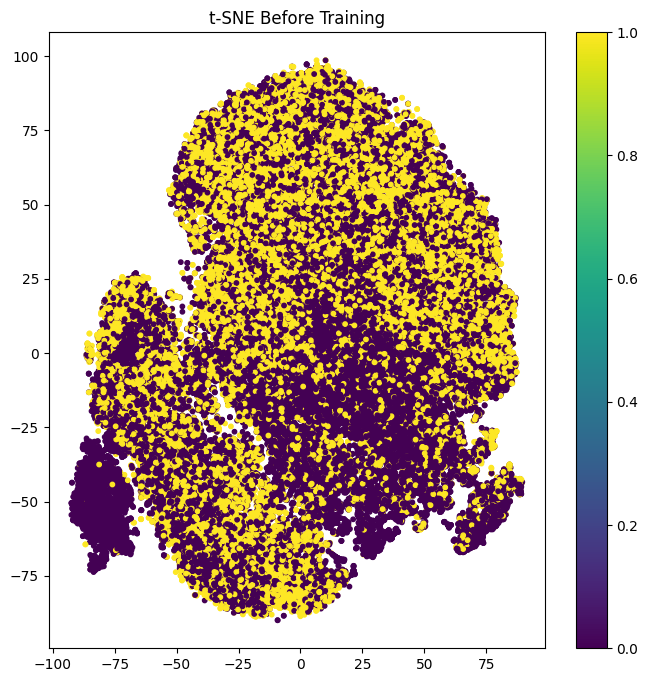

In [16]:
# --------- 8. t-SNE Visualization ---------
def plot_tsne(features, labels, title, save_path):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features)
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='viridis', s=10)
    plt.colorbar()
    plt.title(title)
    plt.savefig(save_path)
    plt.show()

# t-SNE before training
plot_tsne(features[:80000], labels[:80000], "t-SNE Before Training", "tsne_before.png")

In [17]:
# t-SNE after training
model.eval()

AttentionModel(
  (embedding): Linear(in_features=1084, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

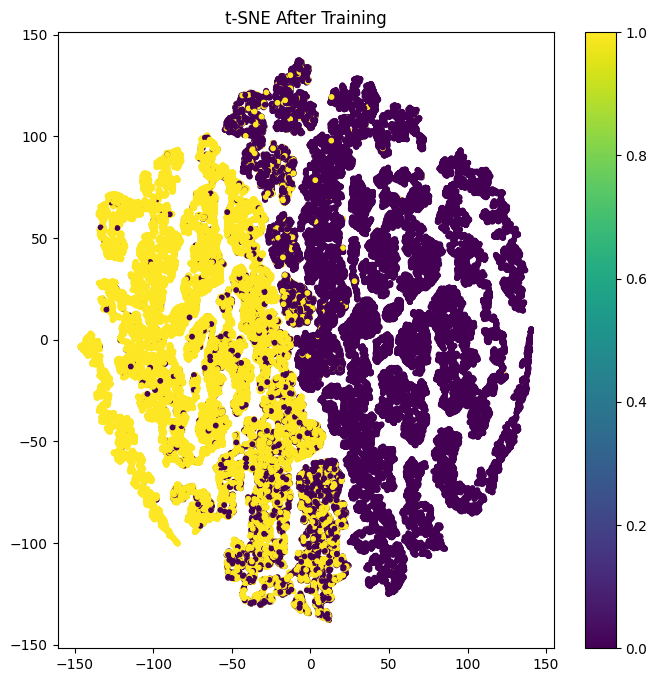

In [18]:
# Use torch.float32 dtype for input
with torch.no_grad():
    final_embeddings, _ = model(torch.tensor(features[:80000], dtype=torch.float32).cuda())  # Get only the embeddings (ignore attention_weights)
    final_embeddings = final_embeddings.cpu().numpy()  # Convert embeddings to CPU for visualization

plot_tsne(final_embeddings, labels[:80000], "t-SNE After Training", "tsne_after.png")



In [19]:
print(model)

AttentionModel(
  (embedding): Linear(in_features=1084, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [20]:
def model_summary(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params}")
    for name, param in model.named_parameters():
        print(f"{name}: {param.size()}")

model_summary(model)


Total Parameters: 238722
embedding.weight: torch.Size([128, 1084])
embedding.bias: torch.Size([128])
attention.in_proj_weight: torch.Size([384, 128])
attention.in_proj_bias: torch.Size([384])
attention.out_proj.weight: torch.Size([128, 128])
attention.out_proj.bias: torch.Size([128])
fc1.weight: torch.Size([256, 128])
fc1.bias: torch.Size([256])
fc2.weight: torch.Size([2, 256])
fc2.bias: torch.Size([2])
layer_norm.weight: torch.Size([128])
layer_norm.bias: torch.Size([128])


In [21]:
pwd

'C:\\Notebooks'

In [23]:
# Saving the model
# Define local directory to save the model

save_directory = r"C:\Notebooks\rrl_source\Spectnet_model_embedding"  # Replace with your preferred path
os.makedirs(save_directory, exist_ok=True)  # Create directory if it doesn't exist

# Define file paths for model and weights
model_path = os.path.join(save_directory, "specnet_model.pth")
weights_path = os.path.join(save_directory, "specnet_weights.pth")

# Save the trained SpecNet model and weights
torch.save(model.state_dict(), weights_path)  # Save weights
torch.save(model, model_path)                # Save the entire model

print(f"Trained model saved at: {model_path}")
print(f"Trained model weights saved at: {weights_path}")



Trained model saved at: C:\Notebooks\rrl_source\Spectnet_model_embedding\specnet_model.pth
Trained model weights saved at: C:\Notebooks\rrl_source\Spectnet_model_embedding\specnet_weights.pth


In [27]:
# Loading the model
# Define the paths to the saved model and weights
os.chdir(r'C:\Notebooks\rrl_source\Spectnet_model_embedding')

model_path = ".\specnet_model.pth"  # Replace with your saved model path
weights_path = ".\specnet_weights.pth"  # Replace with your weights path

def load_model_from_local(model_path, weights_path, device="cuda"):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    
    # Load the full model
    loaded_model = torch.load(model_path, map_location=device)
    loaded_model.eval()  # Set the model to evaluation mode
    print("Model and weights successfully loaded from local directory.")
    return loaded_model

# Load the model
device = "cuda"  # Specify the device to load the model
loaded_model = load_model_from_local(model_path, weights_path, device)


Model and weights successfully loaded from local directory.


C:\Users\mawais\AppData\Local\Temp\ipykernel_25236\48384422.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(model_path, map_location=device)


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Define a custom dataset
class FeatureDataset(Dataset):
    def __init__(self, features):
        self.features = torch.tensor(features, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx]

# Function to extract embeddings
def extract_embeddings(features, model, device="cuda"):
    model.eval()  # Set the model to evaluation mode
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model.to(device)

    dataset = FeatureDataset(features)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    embeddings_128 = []
    embeddings_256 = []

    with torch.no_grad():  # No gradients required for inference
        for batch in dataloader:
            batch = batch.to(device)
            # Forward pass through the model
            embedded = model.embedding(batch)  # Output of the embedding layer (128 features)
            attention_output, _ = model.attention(embedded.unsqueeze(1), embedded.unsqueeze(1), embedded.unsqueeze(1))
            normed_output = model.layer_norm(attention_output.squeeze(1))  # Output of LayerNorm (128 features)
            embeddings_128.append(normed_output.cpu().numpy())
            
            fc1_output = model.fc1(normed_output)  # Output of fc1 (256 features)
            embeddings_256.append(fc1_output.cpu().numpy())
    
    return np.vstack(embeddings_128), np.vstack(embeddings_256)

# Main function
def process_features_and_save_embeddings(input_csv, output_csv_128, output_csv_256, model, device="cuda"):
    # Load the feature data
    data = pd.read_csv(input_csv)
    
    # Extract necessary columns
    file_ids = data.iloc[:, 0].values  # FileID
    features = data.iloc[:, 1:-1].values  # Features
    labels = data.iloc[:, -1].values  # Label

    # Extract embeddings
    embeddings_128, embeddings_256 = extract_embeddings(features, model, device)

    # Create DataFrames for 128 and 256 features
    embedding_columns_128 = [f"Feature{i+1}" for i in range(embeddings_128.shape[1])]
    df_embeddings_128 = pd.DataFrame(embeddings_128, columns=embedding_columns_128)
    df_embeddings_128.insert(0, "FileID", file_ids)
    df_embeddings_128["Label"] = labels

    embedding_columns_256 = [f"Feature{i+1}" for i in range(embeddings_256.shape[1])]
    df_embeddings_256 = pd.DataFrame(embeddings_256, columns=embedding_columns_256)
    df_embeddings_256.insert(0, "FileID", file_ids)
    df_embeddings_256["Label"] = labels

    # Save the updated DataFrames to CSV files
    df_embeddings_128.to_csv(output_csv_128, index=False)
    df_embeddings_256.to_csv(output_csv_256, index=False)
    print(f"Embeddings saved to {output_csv_128} and {output_csv_256}")

# Paths
input_csv = r"C:\Notebooks\rrl_source\Spectnet_model_Halftruth_embedding\features.csv"  # Input file
output_csv_128 = r"C:\Notebooks\rrl_source\Spectnet_model_Halftruth_embedding\feature_emb_128.csv"  # 128 features file
output_csv_256 = r"C:\Notebooks\rrl_source\Spectnet_model_Halftruth_embedding\feature_emb_256.csv"  # 256 features file
model_path = r".\specnet_Halftruth_model.pth"  # Model path
device = "cuda"

# Load the model
def load_model(model_path, device):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = torch.load(model_path, map_location=device)
    model.eval()
    print("Model loaded successfully.")
    return model

loaded_model = load_model(model_path, device)

# Process the CSV and save embeddings
process_features_and_save_embeddings(input_csv, output_csv_128, output_csv_256, loaded_model, device)

In [31]:
final_embeddings.shape

(80000, 2)